# Dynamic Economic Dispatch (DED)
This notebook is inspired by Chapter 4 of the following book:<br>
Soroudi, Alireza. Power system optimization modeling in GAMS. Vol. 78. Berlin/Heidelberg, Germany: Springer, 2017.

In [1]:
using JuMP
using DataFrames
using Plots
using HiGHS
using LaTeXStrings
using Juniper
using Ipopt
import MathOptInterface as MOI

**Problem Description:**<br>
Consider a power plant with a few thermal generators. Each generator can produce power within a specified lower and upper bound. The rate at which a thermal generator can ramp up its generation is given by $RU_{g}$, and the rate at which it can ramp its power generation down is given by $RD_{g}$. The goal of Dynamic Economic Dispatch (DED) is to minimize the total cost of generation, while meeting the demand. The cost of power generation for each thermal generator follows a quadratic function, as follows:
$$
C(P_{g,t}) = a_{g}P_{g,t}^{2} + b_{g}P_{g,t} + c_{g}
$$
where $a_{g}$, $b_{g}$, and $c_{g}$ are the cost coefficients for the thermal unit $g$ and $P_{g,t}$ is the energy production of unit $g$ at timestep $t$. Therefore, the total cost is given by:
$$
TC = \sum_{g,t}^{} C(P_{g,t})
$$
Similar to production cost, total emission from the thermal units can be calculated as follows:
$$
EM = \sum_{g,t}^{} d_{g}P_{g,t}^{2} + e_{g}P_{g,t} + f_{g}
$$
The thermal units can only generate power, within their opearating limits:
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$

# 1. Cost-based Economic Dispatch
In this section we only consider the total cost of power generation from the thermal units, and we want the total power generation to meet the demand. So the problem can be summarized as follows:

**Mathematical representation:**<br>
$$
\underset{P_{g,t}}{min} \; TC = \sum_{g,t}^{} a_{g}P_{g,t}^{2} + b_{g}P_{g,t} + c_{g}
$$
$$
EM = \sum_{g,t}^{} d_{g}P_{g,t}^{2} + e_{g}P_{g,t} + f_{g}
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
\sum_{g}^{} P_{g,t} \ge L_{t}
$$

The following table provides the cost and emission coefficients, as well as operating limits of the thermal generators:

In [2]:
ded_df = DataFrame();
ded_df[!, :g] = ["g1", "g2", "g3", "g4"];
ded_df[!, :a_g] = [0.12, 0.17, 0.15, 0.19];
ded_df[!, :b_g] = [14.8, 16.57, 15.55, 16.21];
ded_df[!, :c_g] = [89., 83., 100., 70.];
ded_df[!, :d_g] = [1.2, 2.3, 1.1, 1.1];
ded_df[!, :e_g] = [-5, -4.24, -2.15, -3.99];
ded_df[!, :f_g] = [3, 6.09, 5.69, 6.2];
ded_df[!, :P_min] = [28., 20., 30., 20.];
ded_df[!, :P_max] = [200., 290., 190., 260.];
ded_df[!, :RU_g] = [40., 30., 30., 50.];
ded_df[!, :RD_g] = [40., 30., 30., 50.];

ded_df

Row,g,a_g,b_g,c_g,d_g,e_g,f_g,P_min,P_max,RU_g,RD_g
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,g1,0.12,14.8,89.0,1.2,-5.0,3.0,28.0,200.0,40.0,40.0
2,g2,0.17,16.57,83.0,2.3,-4.24,6.09,20.0,290.0,30.0,30.0
3,g3,0.15,15.55,100.0,1.1,-2.15,5.69,30.0,190.0,30.0,30.0
4,g4,0.19,16.21,70.0,1.1,-3.99,6.2,20.0,260.0,50.0,50.0


The following are timeseries data for demand, available wind power, and wind power price. In this section we only need the demand timeseries. The other timeseries data are needed for future sections where wind generation is added to the problem.

In [3]:
demands_vec = [510., 530., 516., 510., 515., 544., 646., 686., 741., 734., 748., 760., 754., 700., 686., 720., 714., 761., 727., 714., 618., 584., 578., 544.];
wind_availability = [44.1, 48.5, 65.7, 144.9, 202.3, 317.3, 364.4, 317.3, 271, 306.9, 424.1, 398, 487.6, 521.9, 541.3, 560, 486.8, 372.6, 367.4, 314.3, 316.6, 311.4, 405.4, 470.4];
lambda_e = [32.71, 34.72, 32.71, 32.74, 32.96, 34.93, 44.9, 52, 53.03, 47.26, 44.07, 38.63, 39.91, 39.45, 41.14, 39.23, 52.12, 40.85, 41.2, 41.15, 45.76, 45.59, 45.56, 34.72];
lambda_r = [25.55, 20.83, 19.68, 21.73, 22.43, 23.94, 42.22, 36.53, 21.41, 12.58, 13.86, 9.58, 7.18, 12.16, 18.20, 17.83, 24.13, 18.80, 18.02, 17.03, 13.37, 16.94, 19.05, 13.58];

Given all the information above, we can formulate the optimization problem in JuMP.<br>

In [4]:
Base.@kwdef mutable struct model_options
        g::Int = 4                         # Nmber of thermal generators
        t::Int = 24                        # Optimization horizon in hours
        a::Vector{Float64}                 # Thermal generator cost coefficient
        b::Vector{Float64}                 # Thermal generator cost coefficient
        c::Vector{Float64}                 # Thermal generator cost coefficient
        d::Vector{Float64}                 # Thermal generator emission coefficient
        e::Vector{Float64}                 # Thermal generator emission coefficient
        f::Vector{Float64}                 # Thermal generator emission coefficient
        RU::Vector{Float64}                # Thermal generator ramp-up rate
        RD::Vector{Float64}                # Thermal generator ramp-down rate
        P_min::Vector{Float64}             # Thermal generator power lower bound
        P_max::Vector{Float64}             # Thermal generator power upper bound
        demands::Vector{Float64}           # Forecasted demand in the optimization horizon
        epsilon::Float64 = 1e12            # Emission limit
        wind_avlblty::Vector{Float64} = [] # Available power from wind assets
        VWC::Int = 0                       # Cost of wind curtailment
        lambda_e::Vector{Float64} = []     # energy price forecast
        lambda_r::Vector{Float64} = []     # reserve price forecast
        emission_limit::Bool = false       # Boolean variable denoting whether emission constraint is applied
        wind_asset::Bool = false           # Boolean variable denoting whether a wind asset is included in the optimization
        price_based::Bool = false          # Boolean variable denoting whether optimization is based on price
        price_based_reserve::Bool = false  # Boolean variable denoting whether optimization is based on price with reserve
end

model_options

In [5]:
function build_model(opt::model_options)
    
    model = Model(Ipopt.Optimizer);
    set_silent(model);
    
    #Variables
    @variable(model, P[i = 1:opt.g, j=1:opt.t] >=0);
    #If there is a wind asset, add wind variables
    if opt.wind_asset
        @variable(model, Pwc[j=1:opt.t] >=0);
        @variable(model, Pw[j=1:opt.t] >=0);
    end
    if opt.price_based_reserve
        @variable(model, SR[i = 1:opt.g, j=1:opt.t] >=0);
    end

    #Constraints
    c_P_min = @constraint(model, [i = 1:opt.g, j=1:opt.t], P[i,j] >= opt.P_min[i]);
    c_P_max = @constraint(model, [i = 1:opt.g, j=1:opt.t], P[i,j] <= opt.P_max[i]);

    c_ramp_up = @constraint(model, [i = 1:opt.g, j=2:opt.t], (P[i,j] - P[i,j-1]) <= opt.RU[i]);
    c_ramp_down = @constraint(model, [i = 1:opt.g, j=2:opt.t], (P[i,j-1] - P[i,j]) <= opt.RD[i]);

    c_demand_generation = @constraint(model, [j = 1:opt.t], sum(P[:,j]) >= opt.demands[j]);
    
    tot_em = @expression(model, sum((opt.d[g_]*(model[:P][g_,t_])^2 + opt.e[g_]*(model[:P][g_,t_]) +
        opt.f[g_]) for g_=1:opt.g for t_=1:opt.t))
    
    if opt.emission_limit
        c_total_emission_limit = @constraint(model, tot_em <= opt.epsilon);
    end
    
    @objective(model, Min, sum((opt.a[g_]*P[g_,t_]^2 + opt.b[g_]*P[g_,t_] + opt.c[g_]) for g_=1:opt.g for t_=1:opt.t) );
    
    # For wind assets only
    if opt.wind_asset
        delete(model, c_demand_generation)
        c_demand_generation_with_wind = @constraint(model, [j=1:opt.t], Pw[j] + sum(P[:,j]) >= opt.demands[j]);
        c_wind_generation_limit = @constraint(model, [j=1:opt.t], Pw[j] + Pwc[j] <= opt.wind_avlblty[j]);
        @objective(model, Min, sum((opt.a[g_]*P[g_,t_]^2 + opt.b[g_]*P[g_,t_] + opt.c[g_]) for g_=1:opt.g for t_=1:opt.t) +
                                sum(opt.VWC.*Pwc[t_] for t_ in opt.t) );
    end
    
    # For price-based optimization only 
    if opt.price_based
        delete(model, c_demand_generation)
        c_demand_generation_price_based = @constraint(model, [j = 1:opt.t], sum(P[:,j]) <= opt.demands[j]);
        @objective(model, Max, sum((opt.lambda_e[t_]*P[g_,t_]) for g_=1:opt.g for t_=1:opt.t)- 
                        sum((opt.a[g_]*P[g_,t_]^2 + opt.b[g_]*P[g_,t_] + opt.c[g_]) for g_=1:opt.g for t_=1:opt.t) );
    end
    
    # For price-based optimization with reserve only 
    if opt.price_based_reserve
        delete(model, c_demand_generation)
        c_demand_generation_price_based = @constraint(model, [j = 1:opt.t], sum(P[:,j]) <= opt.demands[j]);
        c_max_reserve = @constraint(model, [i=1:opt.g, j=1:opt.t], SR[i,j] <= opt.P_max[i] - P[i,j]);
        @objective(model, Max, sum((opt.lambda_r[t_]*SR[g_,t_] + opt.lambda_e[t_]*P[g_,t_] - 
                    opt.a[g_]*P[g_,t_]^2 - opt.b[g_]*P[g_,t_] - opt.c[g_]) for g_=1:opt.g for t_=1:opt.t) );
    end
                                            
    return model
end

build_model (generic function with 1 method)

**Note:**<br>
In this section, we are only considering cost-based economic dispatch optimization for thermal generators withouth emission considerations. Therefore, we set the constraints related to wind generation, and emissions to be disregarded in the model options, as follows:

In [6]:
model_options_thermal = model_options(a=ded_df[!, :a_g], b=ded_df[!, :b_g], c=ded_df[!, :c_g], d=ded_df[!, :d_g],
        e=ded_df[!, :e_g], f=ded_df[!, :f_g], RU=ded_df[!, :RU_g], RD=ded_df[!, :RD_g],
        P_min=ded_df[!, :P_min], P_max=ded_df[!, :P_max], demands=demands_vec);

In [7]:
model = build_model(model_options_thermal)
optimize!(model)

println("Total operating cost is \$", objective_value(model))
EM = sum((model_options_thermal.d[g_]*value(model[:P][g_,t_])^2 + model_options_thermal.e[g_]*value(model[:P][g_,t_]) + 
        model_options_thermal.f[g_]) for g_=1:model_options_thermal.g for t_=1:model_options_thermal.t)
println("Total emissiom is ", EM, " tons")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total operating cost is $647964.4487757282
Total emissiom is 3.592886713218896e6 tons


**Note:**<br>
In this section, we are only considering cost-based economic dispatch optimization for thermal generators withouth emission considerations. Therefore, we disregard the constraints related to wind generation, and emissions in the above Pyomo model. This can be done as follows:

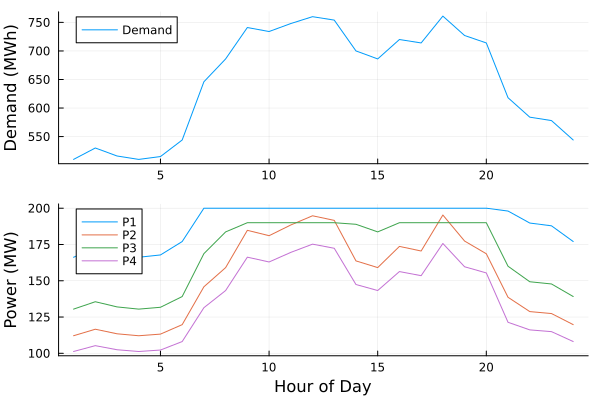

In [8]:
p1 = plot(range(1, 24, length=24), demands_vec, label="Demand")
yaxis!("Demand (MWh)")

p2 = plot(range(1, 24, length=24), value.(model[:P][1,:]), label="P1")
p2 = plot!(range(1, 24, length=24), value.(model[:P][2,:]), label="P2")
p2 = plot!(range(1, 24, length=24), value.(model[:P][3,:]), label="P3")
p2 = plot!(range(1, 24, length=24), value.(model[:P][4,:]), label="P4")
xaxis!("Hour of Day")
yaxis!("Power (MW)")
plot(p1, p2, layout=(2,1))

**Ramp Up/Down Sensitivity:**<br>
We can change the values of $RU_{g}$ and $RD_{g}$ to see how they affect total cost and emissions. We can consider a range of values for ramp rate and solve the problem accordingly. For each generator, we can apply a ramp scale, strating from 60% of its original value, up to 100% of its original value and observe the results:

In [9]:
ramp_sensitivity_df = DataFrame([[],[],[]], ["Ramp_Scale", "Total_Cost","Total_Emission"]);
model_options_rs = model_options_thermal
for i=58:2:100
    model_options_rs.RU = ded_df[!, :RU_g] .* i / 100
    model_options_rs.RD = ded_df[!, :RD_g] .* i / 100
    
    model = build_model(model_options_rs)
    optimize!(model)
    EM = sum((model_options_rs.d[g_]*value(model[:P][g_,t_])^2 + model_options_rs.e[g_]*value(model[:P][g_,t_]) + 
        model_options_rs.f[g_]) for g_=1:model_options_rs.g for t_=1:model_options_rs.t)
    push!(ramp_sensitivity_df, [i/100, objective_value(model), EM])
end

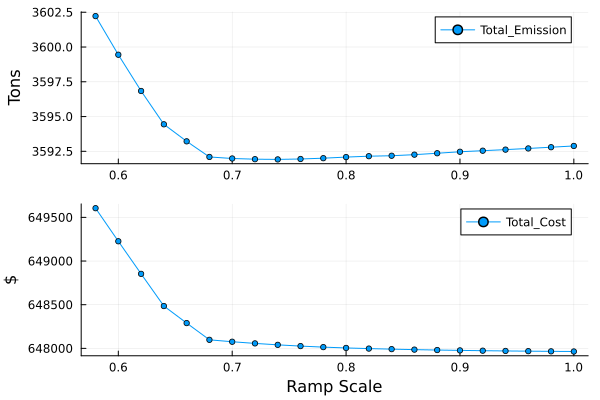

In [10]:
p1 = plot(ramp_sensitivity_df[!,:Ramp_Scale], ramp_sensitivity_df[!,:Total_Emission] ./ 1000, marker=(:circle,3),
    label="Total_Emission")
yaxis!("Tons")
p2 = plot(ramp_sensitivity_df[!,:Ramp_Scale], ramp_sensitivity_df[!,:Total_Cost], marker=(:circle,3), label="Total_Cost")
xaxis!("Ramp Scale")
yaxis!(L"$")
plot(p1, p2, layout=(2,1))

# 1.1. Multi-Objective optimization
So far we only considered total cost of power generation in the optimization process. In the following section, we also add emission considerations, and produce a Pareto optimal front. To do so we need to add another constraint for the amount of emissions, as follows:<br>
$$
EM \le \epsilon
$$
where $\epsilon$ is the maximum allowable emissions. In order to look at the effect of emissions on optimal cost, we can very the value of $\epsilon$ between $EM^{min}$ and $EM^{max}$, and create a Pareto front. So the oprimization problem can now be represented as the following:<br>
**Mathematical representation:**<br>
$$
\underset{P_{g,t}}{min} \; TC = \sum_{g,t}^{} a_{g}P_{g,t}^{2} + b_{g}P_{g,t} + c_{g}
$$
$$
EM \le \epsilon
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
\sum_{g}^{} P_{g,t} \ge L_{t}
$$

In [11]:
#We set the emission limit constraint to TRUE
model_options_em = deepcopy(model_options_thermal)
model_options_em.emission_limit=true

emission_cost_df = DataFrame([[],[],[]], ["Epsilon", "Total_Cost", "Total_Emission"]);
for ep=3.28e6:2e4:3.6e6
    model_options_em.epsilon = ep
    model = build_model(model_options_em)
    optimize!(model)
    EM = sum((model_options_em.d[g_]*value(model[:P][g_,t_])^2 + model_options_em.e[g_]*value(model[:P][g_,t_]) + 
        model_options_em.f[g_]) for g_=1:model_options_em.g for t_=1:model_options_em.t)
    push!(emission_cost_df, [ep, objective_value(model), EM])
end

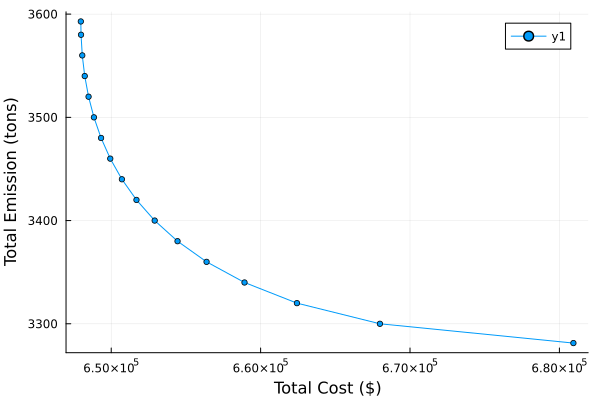

In [12]:
p1 = plot(emission_cost_df[!,:Total_Cost], emission_cost_df[!,:Total_Emission] ./ 1000, marker=(:circle,3) )
xaxis!("Total Cost (\$)")
yaxis!("Total Emission (tons)")
plot(p1, layout=(1,1))

# Optimal solution on the Pareto front
To find the optimal solution with respect to both total emission and cost, we can look at the solutions that fall on the Pareto optimal fron and use a fuzzy satisfying method. A linear membership function can be defined as follows:
$$
\mu^{f_{k}(X_{c})} =
    \begin{cases}
      0 & \text{otherwise}\\
      \frac{f_{k}^{max} - f_{k}(X_{c})}{f_{k}^{max} - f_{k}^{min}} & f_{k}^{min} \le f_{k}(X_{c}) \le f_{k}^{max}\\
    \end{cases}
$$
<br>
$$
F_{z}(X_{c}) = \underset{}{min} \; \mu^{f_{k}(X_{c})} \;\;\;\;\;\;\;\; \forall k
$$
where $X_{c}$ are the points on the Pareto optimal front, and $f_{k}$ are each of the functions upon which the Pareto optimal fron is formed. In the case of this problem for ecxample, $f_{1} = Total \; Cost$ and $f_{2} = Total \; Emission$. Using this formulation, we can calculate the membership functions as follows:

In [13]:
emission_cost_df[!, :mu_TC] = (maximum(emission_cost_df[!,:Total_Cost]) .- emission_cost_df[!,:Total_Cost]) ./ 
                                (maximum(emission_cost_df[!,:Total_Cost]) - minimum(emission_cost_df[!,:Total_Cost]));
emission_cost_df[!, :mu_EM] = (maximum(emission_cost_df[!,:Total_Emission]) .- emission_cost_df[!,:Total_Emission]) ./ 
                                (maximum(emission_cost_df[!,:Total_Emission]) - minimum(emission_cost_df[!,:Total_Emission]));
emission_cost_df[!, :Fz] = minimum.(eachrow(emission_cost_df[!,[:mu_TC,:mu_EM]]))
first(emission_cost_df, 5)

Row,Epsilon,Total_Cost,Total_Emission,mu_TC,mu_EM,Fz
,Any,Any,Any,Float64,Float64,Float64
1,3.28e6,6.80938e5,3.28132e6,0.0,1.0,0.0
2,3.3e6,6.67986e5,3.3e6,0.392782,0.940033,0.392782
3,3.32e6,6.62432e5,3.32e6,0.561238,0.875842,0.561238
4,3.34e6,6.58922e5,3.34e6,0.667686,0.811651,0.667686
5,3.36e6,6.56382e5,3.36e6,0.744731,0.74746,0.744731


Based on this method, the optimal solution on the Pareto optimal front can be found where $F_{z}$ is maximized. Therefore:

In [14]:
println("The optimal total cost is \$", emission_cost_df[argmax(emission_cost_df[!,:Fz]),:Total_Cost])
println("The optimal total emission is ", emission_cost_df[argmax(emission_cost_df[!,:Fz]),:Total_Emission]/1000, " tons")

The optimal total cost is $656381.5083405272
The optimal total emission is 3360.000000099978 tons


# 1.2. Wind Integrated Dynamic Economic Dispatch
In the previous sections, we only considered gas generators for a DED problem. In this section we also add wind generation to the problem. If we asssume that the only cost associated with wind generation comes from curtailment costs, the total cost of generation for gas and wind can be formulated as follows:
$$
TC = \sum_{g,t}^{} a_{g}P_{g,t}^{2} + b_{g}P_{g,t} + c_{g} + \sum_{t}^{} VWC * P^{wc}_{t}
$$
where $VWC=50$ is the cost (value) of wind curtailment, and $P^{wc}$ is the amount of wind power that is curtailed. Considering $\Lambda^{w}_{t}$ as the amount of available wind power and $P^{w}$ as the amount of wind power generation, the optimization problem can be formulated as follows:

$$
\underset{}{min} \; TC = \sum_{g,t}^{} a_{g}P_{g,t}^{2} + b_{g}P_{g,t} + c_{g} + \sum_{t}^{} VWC * P^{wc}_{t}
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
P^{w}_{t} + \sum_{g}^{} P_{g,t} \ge L_{t}
$$
$$
P^{w}_{t} + P^{wc}_{t} \le \Lambda^{w}_{t}
$$

The following table provides a timeseries data for demand, available wind power, electricity price, and resrve electricity price. 

In [15]:
wind_load_df = DataFrame();
wind_load_df[!, :Load] = [510,530,516,510,515,544,646,686,741,734,748,760,754,700,686,720,714,761,727,714,618,584,578,544];
wind_load_df[!, :Wind_Availability] = [44.1, 48.5, 65.7, 144.9, 202.3, 317.3, 364.4, 317.3, 271, 306.9, 424.1, 398, 487.6, 521.9,
                            541.3, 560, 486.8, 372.6, 367.4, 314.3, 316.6, 311.4, 405.4, 470.4];
wind_load_df[!, :lambda_e] = [32.71, 34.72, 32.71, 32.74, 32.96, 34.93, 44.9, 52, 53.03, 47.26, 44.07, 38.63, 39.91, 39.45,
                            41.14, 39.23, 52.12, 40.85, 41.2, 41.15, 45.76, 45.59, 45.56, 34.72];
wind_load_df[!, :lambda_r] = [25.55, 20.83, 19.68, 21.73, 22.43, 23.94, 42.22, 36.53, 21.41, 12.58, 13.86, 9.58, 7.18, 12.16,
                            18.20, 17.83, 24.13, 18.80, 18.02, 17.03, 13.37, 16.94, 19.05, 13.58];
first(wind_load_df, 5)

Row,Load,Wind_Availability,lambda_e,lambda_r
,Int64,Float64,Float64,Float64
1,510,44.1,32.71,25.55
2,530,48.5,34.72,20.83
3,516,65.7,32.71,19.68
4,510,144.9,32.74,21.73
5,515,202.3,32.96,22.43


In [16]:
# For this section we disregard the emission constraints, and add wind constraints
model_options_wind = deepcopy(model_options_thermal)
model_options_wind.wind_asset = true
model_options_wind.VWC = 50
model_options_wind.wind_avlblty = wind_load_df[:, :Wind_Availability]

model = build_model(model_options_wind)
optimize!(model)

println("Total operating cost is \$", objective_value(model))
EM = sum((model_options_wind.d[g_]*value(model[:P][g_,t_])^2 + model_options_wind.e[g_]*value(model[:P][g_,t_]) + 
    model_options_wind.f[g_]) for g_=1:model_options_wind.g for t_=1:model_options_wind.t)
println("Total emissiom is ", EM, " tons")

Total operating cost is $226921.94100722976
Total emissiom is 904570.5561098336 tons


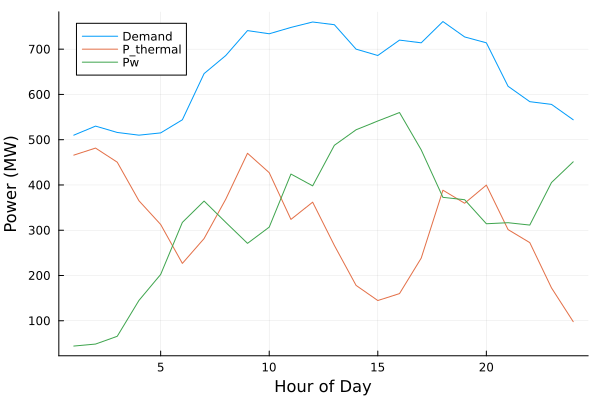

In [17]:
p1 = plot(range(1, 24, length=24), demands_vec, label="Demand")
p1 = plot!(range(1, 24, length=24), value.(sum(model[:P][g_,:] for g_=1:model_options_wind.g)), label="P_thermal")
p1 = plot!(range(1, 24, length=24), value.(model[:Pw][:]), label="Pw")
xaxis!("Hour of Day")
yaxis!("Power (MW)")
plot(p1, layout=(1,1))

# 2. Price-based DED
In price-based DED, the goal is to maximize revenue from power generation, and other services. This means that the demand does not need to be met necessarily. There are two main markets through which revenue is generated: energy market, and ancillaries market. We first look into energy market alone.

# 2.1. Price-based DED in energy market only
In this section we look into price-based DED, when participating only in energy market (no arbitrage). In this case, the goal of optimization is to maximize revenue, which is defined as total income minus total costs. Therefore, revenue can be defined as follows:
$$
\sum_{g,t}^{} \lambda^{e}_{t}P_{g,t} - a_{g}P_{g,t}^{2} - b_{g}P_{g,t} - c_{g}
$$
where $\lambda^{e}_{t}$ is the price of electricity at time $t$.<br>
A major difference between price-based and cost-based DED, is in the power-demand balance. In price-based DED, we can only sell as much elecetricity as there is demand. In other words, electricity generation is limited to demand; therefore the generation-emand constraint is formulated as follows:
$$
\sum_{g,t}^{} P_{g,t} \le L_{T}
$$
The optimization problem then can be formulated as follows:
$$
\underset{P_{g,t}}{max} \; \sum_{g,t}^{} \lambda^{e}_{t}P_{g,t} - a_{g}P_{g,t}^{2} - b_{g}P_{g,t} - c_{g}
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
\sum_{g}^{} P_{g,t} \le L_{t}
$$

In [18]:
# For this section we add the price-based constraints and objective function
model_options_price = deepcopy(model_options_thermal)
model_options_price.price_based = true
model_options_price.lambda_e = wind_load_df[:, :lambda_e]

model = build_model(model_options_price)
optimize!(model)

println("Total operating cost is \$", objective_value(model))
EM = sum((model_options_price.d[g_]*value(model[:P][g_,t_])^2 + model_options_price.e[g_]*value(model[:P][g_,t_]) + 
    model_options_price.f[g_]) for g_=1:model_options_price.g for t_=1:model_options_price.t)
println("Total emissiom is ", EM, " tons")

Total operating cost is $99552.6660616412
Total emissiom is 962833.3825025166 tons


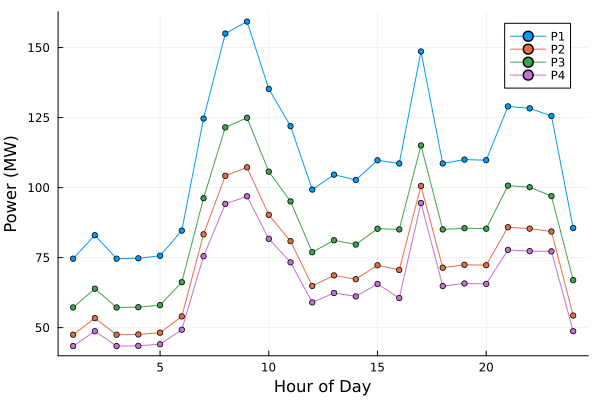

In [19]:
p2 = plot(range(1, 24, length=24), value.(model[:P][1,:]), marker=(:circle,3), label="P1")
p2 = plot!(range(1, 24, length=24), value.(model[:P][2,:]), marker=(:circle,3), label="P2")
p2 = plot!(range(1, 24, length=24), value.(model[:P][3,:]), marker=(:circle,3), label="P3")
p2 = plot!(range(1, 24, length=24), value.(model[:P][4,:]), marker=(:circle,3), label="P4")
xaxis!("Hour of Day")
yaxis!("Power (MW)")
plot(p2, layout=(1,1))

# 2.2. Price-based DED in energy and reserve market
If the thermal generators were to also participate in the reserve market, the problem turns into a price-based DED in both energy and reserve markets. This is usually done in the day-ahead market and the prices for energy and reserves are projections with uncertainty. In this case, the thermal generators can offer some their electricity generation in the reserve market, and the rest in the energy market. Denoting the electricity price by $\lambda^{e}$, spinning reserve price by $\lambda^{r}$, and the amount of energy offered in the reserve market for each thermal generator by $SR_{g,t}$, the net revenue for the generators can be formulated as follows:
$$
\sum_{g,t}^{} \lambda^{e}_{t}P_{g,t} + \lambda^{r}_{t}SR_{g,t} - a_{g}P_{g,t}^{2} - b_{g}P_{g,t} - c_{g}
$$
The only additional constraint for this problem, is the fact that the sum of power generation and spinning reserve offering for each thermal generator should not exceed its operating limits:
$$
0 \le SR_{g,t} \le P_{g}^{max} - P_{g,t}
$$
The optimization problem then can be formulated as follows:
$$
\underset{P_{g,t}}{max} \; \sum_{g,t}^{} \lambda^{e}_{t}P_{g,t} + \lambda^{r}_{t}SR_{g,t} - a_{g}P_{g,t}^{2} - b_{g}P_{g,t} - c_{g}
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
0 \le SR_{g,t} \le P_{g}^{max} - P_{g,t}
$$
$$
\sum_{g}^{} P_{g,t} \le L_{t}
$$

In [20]:
# For this section we add the price-based with reserve constraints and objective function
model_options_price_reserve = deepcopy(model_options_thermal)
model_options_price_reserve.price_based_reserve = true
model_options_price_reserve.lambda_e = wind_load_df[:, :lambda_e]
model_options_price_reserve.lambda_r = wind_load_df[:, :lambda_r]

model = build_model(model_options_price_reserve)
optimize!(model)

println("Total operating cost is \$", objective_value(model))
EM = sum((model_options_price_reserve.d[g_]*value(model[:P][g_,t_])^2 + model_options_price_reserve.e[g_]*value(model[:P][g_,t_]) + 
    model_options_price_reserve.f[g_]) for g_=1:model_options_price_reserve.g for t_=1:model_options_price_reserve.t)
println("Total emissiom is ", EM, " tons")

Total operating cost is $439311.16383173416
Total emissiom is 165626.45796612694 tons


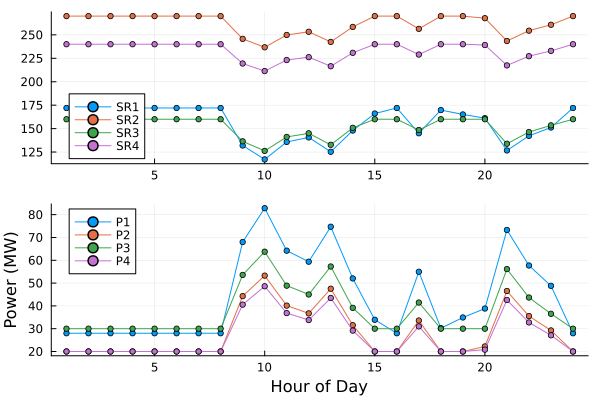

In [21]:
p1 = plot(range(1, 24, length=24), value.(model[:SR][1,:]), marker=(:circle,3), label="SR1")
p1 = plot!(range(1, 24, length=24), value.(model[:SR][2,:]), marker=(:circle,3), label="SR2")
p1 = plot!(range(1, 24, length=24), value.(model[:SR][3,:]), marker=(:circle,3), label="SR3")
p1 = plot!(range(1, 24, length=24), value.(model[:SR][4,:]), marker=(:circle,3), label="SR4")

p2 = plot(range(1, 24, length=24), value.(model[:P][1,:]), marker=(:circle,3), label="P1")
p2 = plot!(range(1, 24, length=24), value.(model[:P][2,:]), marker=(:circle,3), label="P2")
p2 = plot!(range(1, 24, length=24), value.(model[:P][3,:]), marker=(:circle,3), label="P3")
p2 = plot!(range(1, 24, length=24), value.(model[:P][4,:]), marker=(:circle,3), label="P4")
xaxis!("Hour of Day")
yaxis!("Power (MW)")
plot(p1,p2, layout=(2,1))

# 3. Linearizing the DED Problem
The cost of power generation from thermal units, follows a quadratic function, which makes the problem a non-linear optimization problem. We can approximate this function through a series of linear functions, which in turn converts the problem into a linear optimization problem. 

<figure>
<img src=src/LinearizingCostFunction.PNG title="Amazon Rainforest" alt="A drawing of an elephant." style="width:50%">
<figcaption align = "right"> Linear approximation of the cost function (from Soroudi A. Power system optimization modeling in GAMS. Berlin/Heidelberg, Germany: Springer; 2017 Aug 29) </figcaption>
</figure>

To do so, we divide the interval betwen $P_{min}$ and $P_{max}$ into $n$ smaller sub-intervals. If $n$ is big enough, and these sub-intervals are small enough, the cost function can be approximated by a linear function. Using this method, and considering $n=100$ we can formulate the problem as follows:
$$
\underset{P_{g,t}^{k}}{min} \; OF = \; \sum_{g,t}^{} C_{g,t}
$$

$$
0 \le P_{g,t}^{k} \le \Delta P_{g}^{k}, \;\;\; \forall k = 1:n
$$

$$
\Delta P_{g}^{k} = \frac{P_{g}^{max} - P_{g}^{min}}{n}
$$

$$
P_{g,ini}^{k} = (k-1)\Delta P_{g}^{k} + P_{g}^{min}
$$

$$
P_{g,fin}^{k} = P_{g,ini}^{k} + \Delta P_{g}^{k}
$$

$$
Ptot_{g,t} = P_{g}^{min} + \sum_{k}^{} P_{g,t}^{k}
$$

$$
C_{g,t} = a_{g} {(P_{g}^{min})}^2 + b_{g} P_{g}^{min} + c_{g} + \sum_{k}^{} s_{g}^{k} P_{g,t}^{k}
$$
$$
s_{g}^{k} = \frac{C_{g,fin}^{k} - C_{g,ini}^{k}}{\Delta P_{g}^{k}}
$$

$$
C_{g,ini}^{k} = a_{g} {(P_{g,ini}^{k})}^2 + b_{g} P_{g,ini}^{k} + c_{g}
$$
$$
C_{g,fin}^{k} = a_{g} {(P_{g,fin}^{k})}^2 + b_{g} P_{g,fin}^{k} + c_{g}
$$

$$
Ptot_{g,t} - Ptot_{g,t-1} \le RU_{g}
$$
$$
Ptot_{g,t-1} - Ptot_{g,t} \le RD_{g}
$$

$$
\sum_{g,t}^{} Ptot_{g,t} \ge L_{t}
$$

In [22]:
Base.@kwdef mutable struct model_options_linear
        k::Int = 100                       # Nmber of sub-intervals for linearizing the cost function
        g::Int = 4                         # Nmber of thermal generators
        t::Int = 24                        # Optimization horizon in hours
        a::Vector{Float64}                 # Thermal generator cost coefficient
        b::Vector{Float64}                 # Thermal generator cost coefficient
        c::Vector{Float64}                 # Thermal generator cost coefficient
        d::Vector{Float64}                 # Thermal generator emission coefficient
        e::Vector{Float64}                 # Thermal generator emission coefficient
        f::Vector{Float64}                 # Thermal generator emission coefficient
        RU::Vector{Float64}                # Thermal generator ramp-up rate
        RD::Vector{Float64}                # Thermal generator ramp-down rate
        P_min::Vector{Float64}             # Thermal generator power lower bound
        P_max::Vector{Float64}             # Thermal generator power upper bound
        demands::Vector{Float64}           # Forecasted demand in the optimization horizon
end

model_options_linear

In [23]:
function build_linear_model(opt::model_options_linear)
    
    delta_p = (opt.P_max .- opt.P_min) ./ opt.k
    p_ini = [collect(0:opt.k-1) .* delta_p[g_] .+ P_min[g_] for g_=1:opt.g]
    p_ini = mapreduce(permutedims, vcat, p_ini)
    p_fin = [p_ini[g_,:] .+ delta_p[g_] for g_=1:opt.g]
    p_fin = mapreduce(permutedims, vcat, p_fin)
    C_ini = (opt.a .* p_ini .^ 2) .+ (opt.b .* p_ini) .+ opt.c
    C_fin = (opt.a .* p_fin .^ 2) .+ (opt.b .* p_fin) .+ opt.c
    s = (C_fin .- C_ini) ./ delta_p
    
    model = Model(Ipopt.Optimizer);
    set_silent(model);
    
    #Variables
    @variable(model, P[g_=1:opt.g, t_=1:opt.t, k_=1:opt.k] >=0);
    
    @expression(model, Ptot[g_= 1:opt.g, t_=1:opt.t], (opt.P_min[g_]+sum(P[g_, t_, k_] for k_=1:opt.k)))
            
    @expression(model, C[g_= 1:opt.g, t_=1:opt.t], opt.a[g_]*opt.P_min[g_]^2 + opt.b[g_]*opt.P_min[g_] + 
                 opt.c[g_] + sum(s[g_,k_] * P[g_,t_,k_] for k_=1:opt.k));

    #Constraints
    c_P_intvl_max = @constraint(model, [g_=1:opt.g, t_=1:opt.t, k_=1:opt.k], P[g_,t_,k_] <= delta_p[g_]);

    c_ramp_up = @constraint(model, [g_=1:opt.g, t_=2:opt.t], (Ptot[g_,t_] - Ptot[g_,t_-1]) <= opt.RU[g_]);
    c_ramp_down = @constraint(model, [g_=1:opt.g, t_=2:opt.t], (Ptot[g_,t_-1] - Ptot[g_,t_]) <= opt.RD[g_]);

    c_demand_generation = @constraint(model, [t_=1:opt.t], sum(Ptot[:,t_]) >= opt.demands[t_]);
    
    @objective(model, Min, sum(C[g_,t_] for g_=1:opt.g for t_=1:opt.t) );
                                            
    return model
end

build_linear_model (generic function with 1 method)

In [36]:
model_options_linear_thermal = model_options_linear(a=ded_df[!, :a_g], b=ded_df[!, :b_g], c=ded_df[!, :c_g], d=ded_df[!, :d_g],
        e=ded_df[!, :e_g], f=ded_df[!, :f_g], RU=ded_df[!, :RU_g], RD=ded_df[!, :RD_g],
        P_min=ded_df[!, :P_min], P_max=ded_df[!, :P_max], demands=demands_vec)

model_options_linear(100, 4, 24, [0.12, 0.17, 0.15, 0.19], [14.8, 16.57, 15.55, 16.21], [89.0, 83.0, 100.0, 70.0], [1.2, 2.3, 1.1, 1.1], [-5.0, -4.24, -2.15, -3.99], [3.0, 6.09, 5.69, 6.2], [40.0, 30.0, 30.0, 50.0], [40.0, 30.0, 30.0, 50.0], [28.0, 20.0, 30.0, 20.0], [200.0, 290.0, 190.0, 260.0], [510.0, 530.0, 516.0, 510.0, 515.0, 544.0, 646.0, 686.0, 741.0, 734.0  …  686.0, 720.0, 714.0, 761.0, 727.0, 714.0, 618.0, 584.0, 578.0, 544.0])

In [37]:
model = build_linear_model(model_options_linear_thermal)
optimize!(model)

println("Total operating cost is \$", objective_value(model))

Total operating cost is $647972.3959345699


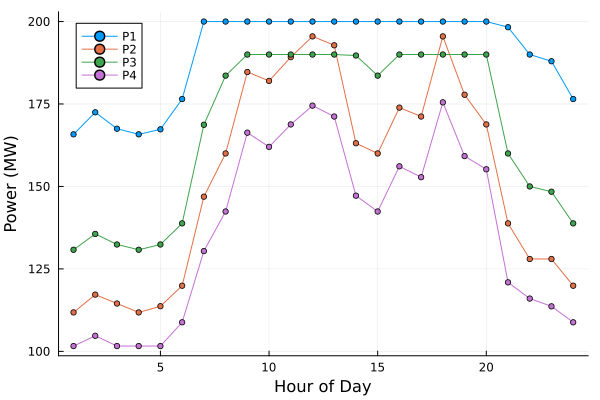

In [38]:
p2 = plot(range(1, 24, length=24), value.(model[:Ptot][1,:]), marker=(:circle,3), label="P1")
p2 = plot!(range(1, 24, length=24), value.(model[:Ptot][2,:]), marker=(:circle,3), label="P2")
p2 = plot!(range(1, 24, length=24), value.(model[:Ptot][3,:]), marker=(:circle,3), label="P3")
p2 = plot!(range(1, 24, length=24), value.(model[:Ptot][4,:]), marker=(:circle,3), label="P4")
xaxis!("Hour of Day")
yaxis!("Power (MW)")
plot(p2, layout=(2,1))